In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
import statsmodels.formula.api as smf

C:\Users\shaba\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Data

Train data obtained from FBI Uniform Crime Reporting on crimes in New York state in 2013.

link: https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls

Test data set obtained from FBI Uniform Crime Reporting on crimes in New York state in 2012.

link: https://ucr.fbi.gov/crime-in-the-u.s/2012/crime-in-the-u.s.-2012/tables/8tabledatadecpdf/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_by_new_york_by_city_2012.xls

In [2]:
#Training will be done on 2013 data
Train =  "New_York_Offenses_2013.csv" 
#Testig will be done on 2013 data
Test = "New_York_Offenses_2012.csv"

In [3]:
# Import data to review
raw_data = pd.read_csv(Train, header = 4)

In [4]:
raw_data.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3'],
      dtype='object')

In [5]:
raw_data.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
0,Adams Village,"1,861",0,0.0,NaN,0,0,0,12,2,10,0,0.0
1,Addison Town and Village,"2,577",3,0.0,NaN,0,0,3,24,3,20,1,0.0
2,Akron Village,"2,846",3,0.0,NaN,0,0,3,16,1,15,0,0.0
3,Albany,"97,956",791,8.0,NaN,30,227,526,"4,090",705,"3,243",142,NaN
4,Albion Village,"6,388",23,0.0,NaN,3,4,16,223,53,165,5,NaN


In [6]:
def import_clean(train_data,city_exclude):
    raw_data = pd.read_csv(train_data, header = 4)
    train_data= raw_data
    train_data.drop(train_data.tail(3).index,inplace=True)
    train_data['Population'] = train_data['Population'].str.replace(',', '')
    train_data['Rape\n(legacy\ndefinition)2'] = train_data['Rape\n(legacy\ndefinition)2'].str.replace(',', '')
    train_data['Property\ncrime'] = train_data['Property\ncrime'].str.replace(',', '')
    train_data['Property\ncrime'] = pd.to_numeric(train_data['Property\ncrime'])
    train_data['Population'] = pd.to_numeric(train_data['Population'])
    train_data['Rape\n(legacy\ndefinition)2'] = pd.to_numeric(train_data['Rape\n(legacy\ndefinition)2'])
    train_data['Robbery'] = train_data['Robbery'].str.replace(',', '')
    train_data['Robbery'] = pd.to_numeric(train_data['Robbery'])
    train_data = train_data[train_data["City"] != city_exclude]
    train_data.rename(columns={"Murder and\nnonnegligent\nmanslaughter":"Murder",'Rape\n(legacy\ndefinition)2':"Rape","Property\ncrime":"Property_Crime"},inplace=True)
    train_data = train_data[["City","Population","Murder","Rape","Property_Crime","Robbery"]]
    train_data= train_data.dropna()
    return train_data
    

In [7]:
def train_import_clean(train_data,city_exclude):
    train_data = import_clean(train_data,city_exclude)
    train_data["population_squared"] = train_data["Population"] **2 
    train_data["Murder"] = np.where(train_data.Murder >= 1, 1,0)
    train_data["Robbery"] = np.where(train_data.Rape >=1,1,0)
    train_data["Rape"] = np.where(train_data.Rape >=1,1,0)
    return train_data

In [8]:
def test_import_clean(test_data,city_exclude):
    raw_test_data = pd.read_csv(test_data, header = 4)
    test_data= raw_test_data
    test_data.drop(test_data.tail(3).index,inplace=True)
    test_data['Population'] = test_data['Population'].str.replace(',', '')
    test_data['Forcible\nrape'] = test_data['Forcible\nrape'].str.replace(',', '')
    test_data['Property\ncrime'] = test_data['Property\ncrime'].str.replace(',', '')
    test_data['Property\ncrime'] = pd.to_numeric(test_data['Property\ncrime'])
    test_data['Burglary'] = test_data['Burglary'].str.replace(',', '')
    test_data['Burglary'] = pd.to_numeric(test_data['Burglary'])  
    test_data['Population'] = pd.to_numeric(test_data['Population'])
    test_data['Forcible\nrape'] = pd.to_numeric(test_data['Forcible\nrape'])
    test_data['Robbery'] = test_data['Robbery'].str.replace(',', '')
    test_data['Robbery'] = pd.to_numeric(test_data['Robbery'])
    test_data = test_data[test_data["City"] != "New York"]
    test_data.rename(columns={"Murder and\nnonnegligent\nmanslaughter":"Murder",'Forcible\nrape':"Rape","Property\ncrime":"Property_Crime"},inplace=True)
    test_data = test_data[["City","Population","Murder","Rape","Property_Crime","Robbery","Burglary"]]
    test_data= test_data.dropna()
    test_data["population_squared"] = test_data["Population"] **2 
    test_data["Murder"] = np.where(test_data.Murder >= 1, 1,0)
    test_data["Robbery"] = np.where(test_data.Rape >=1,1,0)
    test_data["Rape"] = np.where(test_data.Rape >=1,1,0)
    test_data["Burglary"] = np.where(test_data.Burglary >=1,1,0)
    return test_data

In [9]:
#Run clean function then regression
def run_regr(train_file,city_exclude):
    train_data = train_import_clean(train_file,city_exclude)
    regr = linear_model.LinearRegression()
    Y = train_data["Property_Crime"].values.reshape(-1,1)
    X = train_data[["Population","population_squared","Murder","Robbery"]]
    regr.fit(X,Y)
    print('\nCoefficients: \n', regr.coef_)
    print('\nIntercept: \n', regr.intercept_)
    print('\nR-squared:')
    print(regr.score(X, Y))

C:\Users\shaba\Anaconda3\lib\site-packages\pandas\core\frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


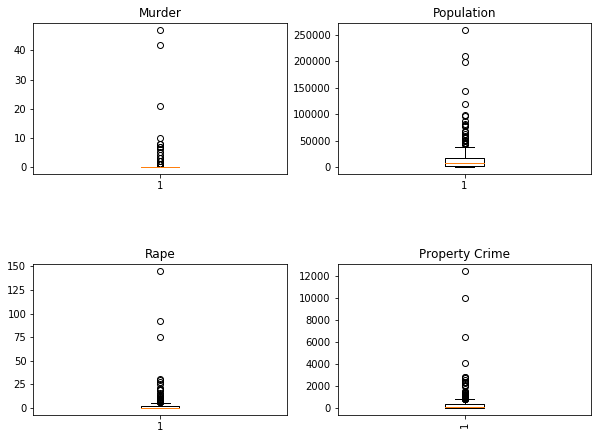

In [10]:
#Boxplots of metrics to be used

data = import_clean(Train,city_exclude="New York")

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
murder = data.Murder
plt.boxplot(murder)
plt.title("Murder")


plt.subplot(2,2,2)
population = data.Population
plt.boxplot(population)
plt.title("Population")


plt.subplot(2,2,3)
rape = data.Rape
plt.boxplot(rape)
plt.title("Rape")

plt.subplot(2,2,4)
property_crime = data.Property_Crime
plt.boxplot(property_crime)
plt.title("Property Crime")
plt.subplots_adjust(bottom = .2 , wspace = .2, hspace = .6)
plt.xticks(rotation ="vertical")
plt.show()

In [11]:
#Run training data regression including New York
run_regr(Train,city_exclude="")


Coefficients: 
 [[  3.44942438e-02  -2.09173197e-09   9.80269105e+00  -5.72140291e+01]]

Intercept: 
 [-140.38524712]

R-squared:
0.996103119783


In [12]:
#Run training data regression excluding New York
run_regr(Train,city_exclude="New York")


Coefficients: 
 [[  1.25121115e-02   1.16273544e-07   1.79123799e+02   1.25216383e+02]]

Intercept: 
 [-4.90693746]

R-squared:
0.845604097004


C:\Users\shaba\Anaconda3\lib\site-packages\pandas\core\frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [13]:
#Use statsmodels to see p-values
def run_statsmodels(train_file,city_exclude):
    train_data = train_import_clean(train_file,city_exclude)
    linear_formula = "Property_Crime ~ Population+population_squared+Murder+Robbery"
    lm = smf.ols(formula=linear_formula, data=train_data).fit()
    print(lm.rsquared)
    print(lm.pvalues)


In [14]:
#Stats models including New York City
run_statsmodels(Train,city_exclude="New York")

0.845604097004
Intercept             8.766804e-01
Population            1.374357e-08
population_squared    1.973108e-25
Murder                2.053089e-02
Robbery               1.713012e-02
dtype: float64


C:\Users\shaba\Anaconda3\lib\site-packages\pandas\core\frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [15]:
#Stats models excluding New York City
run_statsmodels(Train,city_exclude="")

0.996103119783
Intercept             5.867026e-05
Population            2.906356e-96
population_squared    6.616908e-40
Murder                9.122420e-01
Robbery               3.295954e-01
dtype: float64


In [16]:
#Function to train then test on another data set
def run_train_test(train_file,test_file,city_exclude):
    train_data = train_import_clean(train_file,city_exclude)
    test_data = test_import_clean(test_file,city_exclude)
    regr = linear_model.LinearRegression()
    train_y = train_data["Property_Crime"].values.reshape(-1,1)
    train_x = train_data[["Population","population_squared","Murder","Robbery"]]
    test_y = test_data["Property_Crime"].values.reshape(-1,1)
    test_x = test_data[["Population","population_squared","Murder","Robbery"]]    
    regr.fit(train_x,train_y)
    print('\nCoefficients: \n', regr.coef_)
    print('\nIntercept: \n', regr.intercept_)
    print('\nTrain R-squared:')
    print(regr.score(train_x, train_y))   
    print('\nTest R-squared:')
    print(regr.score(test_x, test_y))

In [17]:
#Train 2013 Data, Test 2012, NYC excluded
run_train_test(Train,Test,city_exclude="New York")

C:\Users\shaba\Anaconda3\lib\site-packages\pandas\core\frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)



Coefficients: 
 [[  1.25121115e-02   1.16273544e-07   1.79123799e+02   1.25216383e+02]]

Intercept: 
 [-4.90693746]

Train R-squared:
0.845604097004

Test R-squared:
0.851909304436


In [18]:
#Train 2013 Data, Test 2012, NYC included
run_train_test(Train,Test,city_exclude="")


Coefficients: 
 [[  3.44942438e-02  -2.09173197e-09   9.80269105e+00  -5.72140291e+01]]

Intercept: 
 [-140.38524712]

Train R-squared:
0.996103119783

Test R-squared:
0.787235397682


C:\Users\shaba\Anaconda3\lib\site-packages\pandas\core\frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [19]:
#Holdout
def run_train_test_split(train_file,city_exclude):
    train_data = train_import_clean(train_file,city_exclude)
    regr = linear_model.LinearRegression()
    Y = train_data["Property_Crime"].values.reshape(-1,1)
    X = train_data[["Population","population_squared","Murder","Robbery"]]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=34)
    regr.fit(x_train,y_train)
    y_predict = regr.predict(x_test)
    print('\nCoefficients: \n', regr.coef_)
    print('\nIntercept: \n', regr.intercept_)
    print('\nR-squared:')
    print(regr.score(x_test, y_test))

In [20]:
#Run holdout
run_train_test_split(Train,city_exclude="New York")


Coefficients: 
 [[  9.79891904e-03   1.13696563e-07   1.77175936e+02   1.45681038e+02]]

Intercept: 
 [ 14.96485788]

R-squared:
0.876292002643


C:\Users\shaba\Anaconda3\lib\site-packages\pandas\core\frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [21]:
#Run KFold
def run_KFold(train_file,city_exclude):
    train_data = train_import_clean(train_file,city_exclude)
    regr = linear_model.LinearRegression()
    kf = cross_validation.KFold(n=len(train_data), n_folds=10)
    for train_index, test_index in kf:
        training_data, testing_data = train_data.iloc[train_index], train_data.iloc[test_index]
        training_Y = training_data["Property_Crime"].values.reshape(-1,1)
        training_X = training_data[["Population","population_squared","Murder","Robbery"]]
        testing_Y = testing_data["Property_Crime"].values.reshape(-1,1)
        testing_X = testing_data[["Population","population_squared","Murder","Robbery"]]    
        regr.fit(training_X,training_Y)
        print('\nR-squared:')
        print(regr.score(testing_X,testing_Y))

In [22]:
run_KFold(Train,city_exclude="New York")


R-squared:
0.766883953035

R-squared:
0.938424040287

R-squared:
0.362363551058

R-squared:
0.839857710034

R-squared:
0.753806319831

R-squared:
0.820242739933

R-squared:
0.569472633618

R-squared:
0.902713272846

R-squared:
0.8525739504

R-squared:
-1.6011632284


C:\Users\shaba\Anaconda3\lib\site-packages\pandas\core\frame.py:2746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


As discussed I used various validation methods including KFold and holdouts.  I also brought in a different set of data from a different year and tested prediction on that data as well.  In regards to making adjustments to the model I went through a process of adding and removing features while monitoring the r squared.  I also used statsmodels to see the p-values to help me determine which features where benefiting the model and which weren't.